У нас есть данные АА-теста с '2022-03-08' по '2022-03-14'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandahouse
import scipy.stats as stats
from read_db.CH import Getch

In [3]:
data = Getch('''
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220320.feed_actions
WHERE toDate(time) between '2022-03-08' and '2022-03-14'
    and exp_group in (2,3)
GROUP BY exp_group, user_id''').df

In [4]:
def bootstrap(df1, df2, n=500):
    sample1 = df1.sample(n, replace=True)
    sample2 = df2.sample(n, replace=True)
    pval = stats.ttest_ind(sample1.ctr, sample2.ctr, equal_var=False)[-1]
    
    return pval

In [5]:
df1 = data[data.exp_group == 2]
df2 = data[data.exp_group == 3]

In [6]:
pvl = []
for _ in range(10000):
    pvl.append(bootstrap(df1, df2))

Гистограмма распределения p-values:

<AxesSubplot:ylabel='Count'>

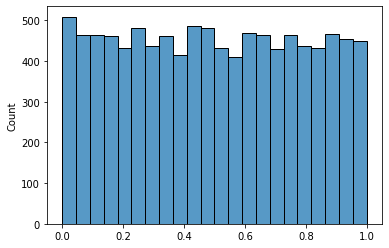

In [7]:
sns.histplot(pvl)

Процент p-values <= 0.05:

In [8]:
pvl1 = np.asarray(pvl)

cond = pvl1 <= 0.05
total = cond.sum()
print(f'Процент p-values <= 0.05 = {total / 10000 * 100}%')

Процент p-values <= 0.05 = 5.54%


Вывод:
Система сплитования работает корректно. p-values распределены равномерно от 0 до 1, процент ложноположительного срабатывания t-теста (p-value меньше 0.05) около 5% - нашего порогового уровня значимости.

На всякий случай проверим, как будет выглядеть картина, если мы "скормим" бутстрепу одну и ту же выборку под видом двух:

Процент p-values <= 0.05 = 5.54%


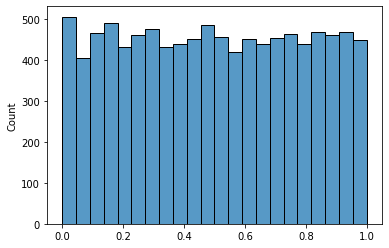

In [10]:
pvl2 = []
for _ in range(10000):
    pvl2.append(bootstrap(df1, df1))

pvl2 = np.asarray(pvl2)
sns.histplot(pvl2)

cond1 = pvl2 <= 0.05
total1 = cond1.sum()
print(f'Процент p-values <= 0.05 = {total1 / 10000 * 100}%')

In [ ]:
Выглядит так же, все правильно